In [1]:
import sys, platform, torch
print("Python:", sys.version)
print("Platform:", platform.platform())
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Python: 3.13.1 (tags/v3.13.1:0671451, Dec  3 2024, 19:06:28) [MSC v.1942 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
PyTorch version: 2.9.0+cpu
CUDA available: False


device(type='cpu')

In [5]:
import os
os.makedirs('project', exist_ok=True)

open(os.path.join("project","train.py"), "w", encoding="utf-8").write('''# train.py
import os, time, argparse, csv
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from models import CNNFromScratch, get_transfer_model
from utils import set_seed, eval_epoch, plot_metrics, plot_confusion_matrix

def build_dataloaders(
    data_root="data", img_size=224, batch_size=32,
    val_split=0.2, augment=True, workers=0, subset=1.0
):
    """
    Charge data/train et fait un split train/val. data/test optionnel.
    subset: fraction du dataset à utiliser (0<subset<=1).
    """
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    if augment:
        train_tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    else:
        train_tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    val_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    ds_full = datasets.ImageFolder(root=os.path.join(data_root, "train"), transform=train_tf)

    # Sous-échantillonnage pour accélérer en CPU
    if subset < 1.0:
        assert 0 < subset <= 1.0, "--subset doit être dans (0,1]"
        sub_len = max(2, int(len(ds_full) * subset))
        rest = len(ds_full) - sub_len
        ds_full, _ = random_split(ds_full, [sub_len, rest], generator=torch.Generator().manual_seed(42))

    # Split 80/20
    n_val = int(val_split * len(ds_full))
    n_train = len(ds_full) - n_val
    train_ds, val_ds = random_split(ds_full, [n_train, n_val], generator=torch.Generator().manual_seed(42))
    val_ds.dataset.transform = val_tf  # pas d'augmentation en val

    # test (optionnel)
    test_loader = None
    test_dir = os.path.join(data_root, "test")
    if os.path.isdir(test_dir) and any(os.scandir(test_dir)):
        test_ds = datasets.ImageFolder(root=test_dir, transform=val_tf)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                                 num_workers=workers, pin_memory=False)

    # DataLoaders (Windows/CPU-friendly)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=workers, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                              num_workers=workers, pin_memory=False)

    return train_loader, val_loader, test_loader, ds_full.dataset.classes if hasattr(ds_full, "dataset") else ds_full.classes


def train_one_epoch(model, loader, device, criterion, optimizer, grad_clip=0.0, max_batches=0):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for i, (images, labels) in enumerate(loader, start=1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        if grad_clip and grad_clip > 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        if max_batches and i >= max_batches:
            break
    train_loss = running_loss / total if total else 0.0
    train_acc = correct / total if total else 0.0
    return train_loss, train_acc


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--exp", choices=["A","B"], default="A", help="A: CNN from scratch, B: transfer learning")
    parser.add_argument("--data_root", type=str, default="data")
    parser.add_argument("--epochs", type=int, default=10)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--optimizer", choices=["adam","sgd"], default="adam")
    parser.add_argument("--scheduler", choices=["step","cosine",None], default="step")
    parser.add_argument("--img_size", type=int, default=224)
    parser.add_argument("--augment", action="store_true")
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--workers", type=int, default=0)  # Windows/CPU safe
    parser.add_argument("--dropout", type=float, default=0.5)
    parser.add_argument("--outdir", type=str, default="runs")
    parser.add_argument("--ckptdir", type=str, default="checkpoints")
    # QoL / CPU
    parser.add_argument("--fast_debug", action="store_true", help="test rapide: epochs/img/batch réduits")
    parser.add_argument("--clip", type=float, default=0.0, help="gradient clipping (0=off)")
    parser.add_argument("--patience", type=int, default=0, help="early stopping sur val_loss (0=off)")
    parser.add_argument("--subset", type=float, default=1.0, help="fraction du dataset train/val à utiliser (0<subset<=1)")
    parser.add_argument("--max_train_batches", type=int, default=0, help="limite de batches par époque (0=pas de limite)")
    # Transfer learning
    parser.add_argument("--pretrained", action="store_true", help="backbone pré-entraîné (B)")
    parser.add_argument("--no_freeze", action="store_true", help="ne pas geler le backbone (B)")
    args = parser.parse_args()

    set_seed(args.seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device} (GPU dispo: {torch.cuda.is_available()})")

    # Limiter les threads CPU (Windows)
    try:
        torch.set_num_threads(min(4, torch.get_num_threads()))
    except Exception:
        pass

    # Fast debug
    if args.fast_debug:
        args.epochs = 1
        args.batch_size = 4
        args.img_size = 128
        args.augment = False
        args.subset = min(args.subset, 0.1)
        args.max_train_batches = max(args.max_train_batches, 50)
        print("[fast_debug] epochs=1, batch=4, img=128, augment=False, subset<=0.1, max_train_batches>=50")

    os.makedirs(args.ckptdir, exist_ok=True)
    os.makedirs(args.outdir,  exist_ok=True)

    # Loaders
    train_loader, val_loader, test_loader, classes = build_dataloaders(
        data_root=args.data_root,
        img_size=args.img_size,
        batch_size=args.batch_size,
        val_split=0.2,
        augment=args.augment,
        workers=args.workers,
        subset=args.subset
    )
    n_train = len(train_loader.dataset)
    n_val   = len(val_loader .dataset)
    n_test  = len(test_loader.dataset) if test_loader is not None else 0
    print(f"Datasets -> train: {n_train} | val: {n_val} | test: {n_test}")

    # Modèle
    if args.exp == "A":
        try:
            model = CNNFromScratch(num_classes=len(classes), dropout_p=args.dropout).to(device)
        except TypeError:
            model = CNNFromScratch().to(device)
    else:
        model = get_transfer_model(
            num_classes=len(classes),
            backbone="resnet18",
            pretrained=args.pretrained,
            freeze_backbone=(not args.no_freeze),
            dropout_p=args.dropout
        ).to(device)

    # Optimiseur
    params = (p for p in model.parameters() if p.requires_grad)
    if args.optimizer == "adam":
        optimizer = optim.Adam(params, lr=args.lr, weight_decay=1e-4)
    else:
        optimizer = optim.SGD(params, lr=args.lr, momentum=0.9, weight_decay=1e-4)

    # Scheduler
    if args.scheduler == "step":
        scheduler = StepLR(optimizer, step_size=max(1, args.epochs//3), gamma=0.1)
    elif args.scheduler == "cosine":
        scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs)
    else:
        scheduler = None

    criterion = nn.CrossEntropyLoss()

    # Historique
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_precision": [], "val_recall": []}

    best_val_acc = -1.0
    best_val_loss = float("inf")
    no_improve = 0
    run_name = f"{'fromscratch' if args.exp=='A' else 'transfer'}_{args.optimizer}_lr{args.lr}"
    best_ckpt = os.path.join(args.ckptdir, f"best_{run_name}.pth")
    last_val_cm = None

    for epoch in range(1, args.epochs + 1):
        t0 = time.time()
        # Train
        train_loss, train_acc = train_one_epoch(
            model, train_loader, device, criterion, optimizer,
            grad_clip=args.clip, max_batches=args.max_train_batches
        )

        # Validation loss
        model.eval()
        val_running_loss, val_total = 0.0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                val_running_loss += criterion(logits, y).item() * y.size(0)
                val_total += y.size(0)
        val_loss = (val_running_loss / val_total) if val_total else 0.0

        # Validation metrics
        val_acc, val_prec, val_rec, val_f1, val_cm = eval_epoch(model, val_loader, device)
        last_val_cm = val_cm

        # Historique
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_precision"].append(val_prec)
        history["val_recall"].append(val_rec)

        # Meilleur checkpoint (sur val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({"model_state": model.state_dict(),
                        "classes": classes,
                        "exp": args.exp}, best_ckpt)

        # Early stopping sur val_loss
        if args.patience > 0:
            if val_loss + 1e-8 < best_val_loss:
                best_val_loss = val_loss
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= args.patience:
                    print(f"Early stopping: pas d'amélioration de val_loss depuis {args.patience} époque(s).")
                    break

        if scheduler is not None:
            scheduler.step()

        dt = time.time() - t0
        print(f"[{epoch}/{args.epochs}] "
              f"train_loss={train_loss:.4f} acc={train_acc:.3f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.3f} prec={val_prec:.3f} rec={val_rec:.3f} | "
              f"{dt:.1f}s")

    # Sorties: figures + matrices + CSV
    out_run = os.path.join(args.outdir, run_name)
    os.makedirs(out_run, exist_ok=True)
    plot_metrics(history, out_run)
    if last_val_cm is not None:
        plot_confusion_matrix(last_val_cm, os.path.join(out_run, "confusion_val.png"), class_names=classes)

    # CSV des métriques
    csv_path = os.path.join(out_run, "history.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch","train_loss","train_acc","val_loss","val_acc","val_precision","val_recall"])
        for i in range(len(history["train_loss"])):
            writer.writerow([
                i+1,
                history["train_loss"][i],
                history["train_acc"][i],
                history["val_loss"][i],
                history["val_acc"][i],
                history["val_precision"][i],
                history["val_recall"][i],
            ])
    print(f"Métriques enregistrées dans {csv_path}")

    # Test final (si présent) en rechargeant le meilleur modèle
    if test_loader is not None and os.path.exists(best_ckpt):
        ckpt = torch.load(best_ckpt, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        test_acc, test_prec, test_rec, test_f1, test_cm = eval_epoch(model, test_loader, device)
        print(f"[TEST] acc={test_acc:.3f} prec={test_prec:.3f} rec={test_rec:.3f} f1={test_f1:.3f}")
        plot_confusion_matrix(test_cm, os.path.join(out_run, "confusion_test.png"), class_names=classes)

if __name__ == "__main__":
    main()
''')

open(os.path.join("project","eval.py"), "w", encoding="utf-8").write('''# eval.py
import argparse, os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from models import CNNFromScratch, get_transfer_model
from utils import eval_epoch, plot_confusion_matrix

def build_loader(data_dir, img_size=224, batch_size=32, workers=0):
    mean=[0.485,0.456,0.406]; std=[0.229,0.224,0.225]
    tf = transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
    ds = datasets.ImageFolder(root=data_dir, transform=tf)
    return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=False), ds.classes

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--ckpt", required=True, help="chemin du .pth")
    ap.add_argument("--data_dir", required=True, help="dossier à évaluer (ex: data/test)")
    ap.add_argument("--exp", choices=["A","B"], required=True)
    ap.add_argument("--img_size", type=int, default=224)
    ap.add_argument("--batch_size", type=int, default=32)
    ap.add_argument("--workers", type=int, default=0)
    ap.add_argument("--out_png", type=str, default="confusion_eval.png")
    args = ap.parse_args()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loader, classes = build_loader(args.data_dir, img_size=args.img_size, batch_size=args.batch_size, workers=args.workers)

    if args.exp == "A":
        model = CNNFromScratch(num_classes=len(classes))
    else:
        model = get_transfer_model(num_classes=len(classes), pretrained=False, freeze_backbone=True)
    ckpt = torch.load(args.ckpt, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    model.to(device)

    acc, prec, rec, f1, cm = eval_epoch(model, loader, device)
    print(f"[EVAL] acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} f1={f1:.3f}")
    plot_confusion_matrix(cm, args.out_png, class_names=classes)
    print(f"Confusion matrix saved to {args.out_png}")

if __name__ == "__main__":
    main()
''')

open(os.path.join("project","models.py"), "w", encoding="utf-8").write('''# models.py
import torch
import torch.nn as nn
from torchvision import models

class CNNFromScratch(nn.Module):
    """
    Version légère (CPU-friendly), toujours 3 blocs Conv+BN+ReLU+MaxPool.
    Canaux: 16 -> 32 -> 64, + AdaptiveAvgPool2d pour indépendance à la taille d'entrée.
    Dropout dans la tête fully-connected.
    """
    def __init__(self, num_classes=2, dropout_p=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),         # -> 64
            nn.Dropout(dropout_p),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def get_transfer_model(
    num_classes=2,
    backbone="resnet18",
    pretrained=True,
    freeze_backbone=True,
    dropout_p=0.5,
):
    """Transfert learning : ResNet18 par défaut (tête remplacée)."""
    b = backbone.lower()
    if b == "resnet18":
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        model = models.resnet18(weights=weights)
        if freeze_backbone:
            for p in model.parameters():
                p.requires_grad = False
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_features, num_classes)
        )
        return model
    raise ValueError(f"Backbone non supporté: {backbone}")
''')

open(os.path.join("project","utils.py"), "w", encoding="utf-8").write('''#utils.py
import random, numpy as np, torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from pathlib import Path

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

@torch.no_grad()
def eval_epoch(model, loader, device):
    """Retourne: acc, precision, recall, f1, confusion_matrix"""
    model.eval()
    total, correct = 0, 0
    preds_all, targets_all = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        preds_all.append(preds.cpu())
        targets_all.append(y.cpu())
    acc = correct / total if total else 0.0
    y_true = torch.cat(targets_all).numpy()
    y_pred = torch.cat(preds_all).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred)
    return acc, precision, recall, f1, cm

def plot_metrics(history, outdir):
    """
    history: dict avec clés
    - train_loss, train_acc, val_loss, val_acc, val_precision, val_recall
    Sauvegarde loss.png, accuracy.png, precision_recall.png
    """
    outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)

    # Loss
    plt.figure()
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"],   label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss"); plt.legend()
    plt.savefig(outdir / "loss.png", dpi=160); plt.close()

    # Accuracy
    plt.figure()
    plt.plot(history["train_acc"], label="train")
    plt.plot(history["val_acc"],   label="val")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy"); plt.legend()
    plt.savefig(outdir / "accuracy.png", dpi=160); plt.close()

    # Precision & Recall
    plt.figure()
    plt.plot(history["val_precision"], label="val_precision")
    plt.plot(history["val_recall"],   label="val_recall")
    plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Precision & Recall"); plt.legend()
    plt.savefig(outdir / "precision_recall.png", dpi=160); plt.close()

def plot_confusion_matrix(cm, outpath, class_names=("cat","dog")):
    import numpy as np
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title("Matrice de confusion"); plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45); plt.yticks(ticks, class_names)
    plt.tight_layout(); plt.ylabel("Vrai"); plt.xlabel("Prédit")
    plt.savefig(outpath, dpi=160); plt.close()
''')

open(os.path.join("project","collect_results.py"), "w", encoding="utf-8").write('''# collect_results.py
import os, csv, glob
def last_row(csv_path):
    with open(csv_path, newline="") as f:
        rows = list(csv.reader(f))
    hdr, data = rows[0], rows[1:]
    if not data: return None
    e = data[-1]
    return {
        "epoch": int(e[0]),
        "train_loss": float(e[1]),
        "train_acc": float(e[2]),
        "val_loss": float(e[3]),
        "val_acc": float(e[4]),
        "val_precision": float(e[5]),
        "val_recall": float(e[6]),
    }

def main():
    runs = sorted(glob.glob("runs/*"))
    print("| Run | Epoch | Val Acc | Val Prec | Val Rec | Train Loss | Val Loss |")
    print("|-----|------:|--------:|---------:|--------:|-----------:|---------:|")
    for r in runs:
        csv_path = os.path.join(r, "history.csv")
        if not os.path.exists(csv_path): continue
        m = last_row(csv_path)
        if not m: continue
        name = os.path.basename(r)
        print(f"| {name} | {m['epoch']} | {m['val_acc']:.3f} | {m['val_precision']:.3f} | {m['val_recall']:.3f} | {m['train_loss']:.3f} | {m['val_loss']:.3f} |")

if __name__ == "__main__":
    import csv
    main()
''')

print("✅ Scripts écrits dans ./project")
import glob, pprint
pprint.pprint(sorted(glob.glob("project/*")))


✅ Scripts écrits dans ./project
['project\\collect_results.py',
 'project\\eval.py',
 'project\\models.py',
 'project\\train.py',
 'project\\utils.py']


In [6]:
import sys, os, glob, textwrap
sys.path.append(os.path.abspath("project"))
print("\n".join(glob.glob("project/*")))

project\collect_results.py
project\eval.py
project\models.py
project\train.py
project\utils.py


In [7]:
# Vérifier la présence des dossiers de données 
DATA_ROOT = "data"  
print("DATA_ROOT =", DATA_ROOT)
print("Contenu data/:", os.listdir(DATA_ROOT) if os.path.isdir(DATA_ROOT) else "dossier absent")

DATA_ROOT = data
Contenu data/: ['.DS_Store', 'test', 'train', 'val']


Classes: ['cat', 'dog'] | Taille train: 22500


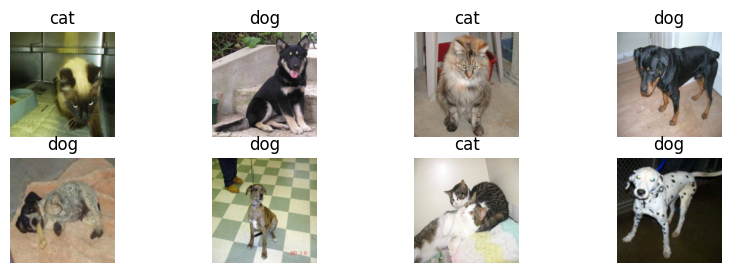

In [8]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

if os.path.isdir(os.path.join(DATA_ROOT, "train")):
    tf = transforms.Compose([transforms.Resize((224,224)) , transforms.ToTensor()])
    ds = datasets.ImageFolder(root=os.path.join(DATA_ROOT, "train"), transform=tf)
    classes = ds.classes
    print("Classes:", classes, "| Taille train:", len(ds))
    loader = DataLoader(ds, batch_size=8, shuffle=True)
    imgs, labels = next(iter(loader))
    plt.figure(figsize=(10,3))
    for i in range(min(8, imgs.size(0))):
        plt.subplot(2,4,i+1)
        plt.imshow(imgs[i].permute(1,2,0))
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()
else:
    print("data/train introuvable – passe.")

ENTRAINEMENT EXPERIENCE A

In [ ]:
%cd project
!python train.py --exp A --epochs 10 --data_root ../data --augment --optimizer adam --lr 0.001 --workers 0
%cd -

c:\Users\hp Zbook\Documents\TP-DeepLearning\project


ENTRAINEMENT EXPERIENCE B

In [ ]:
%cd project
!python train.py --exp B --epochs 10 --data_root ../data --augment --optimizer adam --lr 0.001 --workers 0 --pretrained
%cd -

VISUALISER LES COURBES ET MATRICE DE CONFUSION

In [ ]:
import glob
from IPython.display import display, Image

# Chercher les derniers runs générés
run_dirs = sorted(glob.glob("project/runs/*"))
print("Runs:", run_dirs[-4:])
for rd in run_dirs[-4:]:
    print(f"=== {rd} ===")
    for png in ["loss.png", "accuracy.png", "precision_recall.png", "confusion_val.png", "confusion_test.png"]:
        p = os.path.join(rd, png)
        if os.path.exists(p):
            display(Image(filename=p))

CETTE PARTIE PERMET DE RECAPITULER TOUS LES RESULTATS DANS RUNS

In [ ]:
%cd project
!python collect_results.py
%cd -